In [678]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial import Delaunay

In [679]:
# Helper function to rotate feature kernel
def rotate_point(origin, point, angle):

    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)

    return int(qx), int(qy)

# Node detection kernel, generates feature to detect inside sliding window
def generate_features(win, feature, angle=0, thickness=1):

    # Check that feature is correctly specified
    assert feature in ("cross", "tee", "elbow", "end"), "Feature must be one of 'cross', 'tee', 'elbow', or 'end'."

    # Convert angle to radians
    angle = np.deg2rad(angle)
    
    # Create kernel matrix, if end feature is selected, generate end-detector mask
    kernel = np.zeros((win, win), np.uint8)
    if feature == "end":
        end_mask = np.zeros((win, win), np.uint8)

    # Define center of kernel
    center = win // 2
    origin = (center, center)

    # Draw Top
    if feature in ("cross", "tee", "end"):
        endpoint = rotate_point(origin, (center, -10), angle)
        cv2.line(kernel, origin, endpoint, (1, 1, 1), thickness)
    # Draw Bottom
    if feature == "cross":
        endpoint = rotate_point(origin, (center, win+10), angle)
        cv2.line(kernel, origin, endpoint, (1, 1, 1), thickness)
    # Draw Left 
    if feature in ("cross", "tee"):
        endpoint = rotate_point(origin, (-10, center), angle)
        cv2.line(kernel, origin, endpoint, (1, 1, 1), thickness)
    # Draw Right 
    if feature in ("cross", "tee", "elbow"):
        endpoint = rotate_point(origin, (win+10, center), angle)
        cv2.line(kernel, origin, endpoint, (1, 1, 1), thickness)

    return kernel

In [680]:
# Generate features to search for

deg_ii = 1
kernel = 13
features = []

for theta in range(0, 360, deg_ii):
    if theta % 2 == 0:
        thickness = 1
    else:
        thickness = 4

    feature = generate_features(kernel, feature="end", angle=theta, thickness=thickness)
    features.append(np.asarray(feature))

In [681]:
# # Visualize end segment
# num_features = len(features)
# # Create a figure and a set of subplots
# fig, axs = plt.subplots(2, num_features//4, figsize=(num_features, 5))

# for ii, feature in enumerate(features):
#     # Plot image in subplot
#     axs[ii].imshow(feature, cmap='gray')
#     axs[ii].axis('off')  # Turn off axis


# # Show the plot
# plt.tight_layout()
# plt.show()


In [682]:
# Load image
image = cv2.imread('test_sequence/image2.png', cv2.IMREAD_GRAYSCALE)

# Process image to eliminate floating regions
N = 200 # Minimum number of pixels per region

# Threshold and find contours
_, thresh = cv2.threshold(image, 5, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask for the filtered contours
mask = np.zeros_like(thresh)

# Draw contours for mask
for contour in contours:
    if cv2.contourArea(contour) >= N:
        cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)

# Apply the mask to the original image
img = cv2.bitwise_and(image, image, mask=mask)

# Threshold image
_, img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
img = img.astype(np.uint8)*255

In [690]:
# Find features via template matching

knots = []

for feature in features:
    template = feature * np.max(img)

    # Apply template Matching
    res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    threshold = 0.75
    loc = np.where( res >= threshold)
    if len(loc[0]) > 0:
        knots.append(loc)

# Flatten and pair up point values
knots = [(x, y) for arr1, arr2 in knots for x, y in zip(arr1, arr2)]
len(knots)

7850

In [684]:
# Filter out too-similar points in the array
occurrences = {}
filtered_rows = []

# Iterate over each row in the array
for row in knots:
    # Check if either value in the row has not been seen before
    if occurrences.get(row[0], 0) < 1 and occurrences.get(row[1], 0) < 1:
        # Add the row to the filtered list
        filtered_rows.append(row)
        # Increment the occurrence count for both elements
        occurrences[row[0]] = occurrences.get(row[0], 0) + 1
        occurrences[row[1]] = occurrences.get(row[1], 0) + 1

knots = filtered_rows
len(knots)

252

In [685]:
# Remove any near-duplicate rows

# Similarity threshold
threshold = 10

# Function to check if two rows are similar
def is_similar(row1, row2, thresh):
    row1 = np.asarray(row1)
    row2 = np.asarray(row2)

    return np.all(np.abs(row1 - row2) < thresh)

# Function to remove similar rows
def remove_similar_rows(arr, thresh):
    unique_rows = []

    for current_row in arr:
        # Check if the current row is similar to any already added row
        if not any(is_similar(current_row, unique_row, thresh) for unique_row in unique_rows):
            unique_rows.append(current_row)

    return np.array(unique_rows)


# Process the array
knots = remove_similar_rows(knots, threshold)
print(len(knots))


94


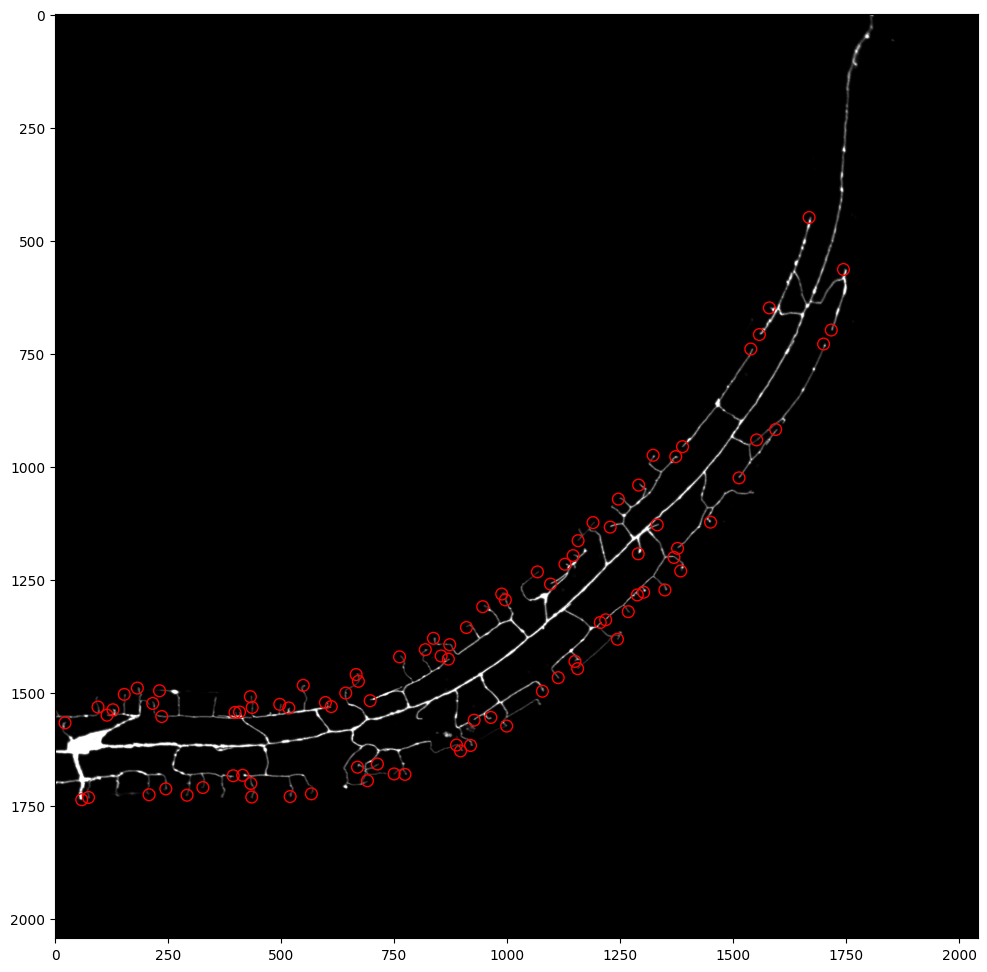

In [686]:
# Plot Vertices on image
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(image, cmap='gray')

# Get template matching offsets
w, h = template.shape[::-1]

# Adding circles at each knot
for xi, yi in knots:
    circle = Circle((yi+w//2, xi+h//2,), radius=(kernel), fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(circle)

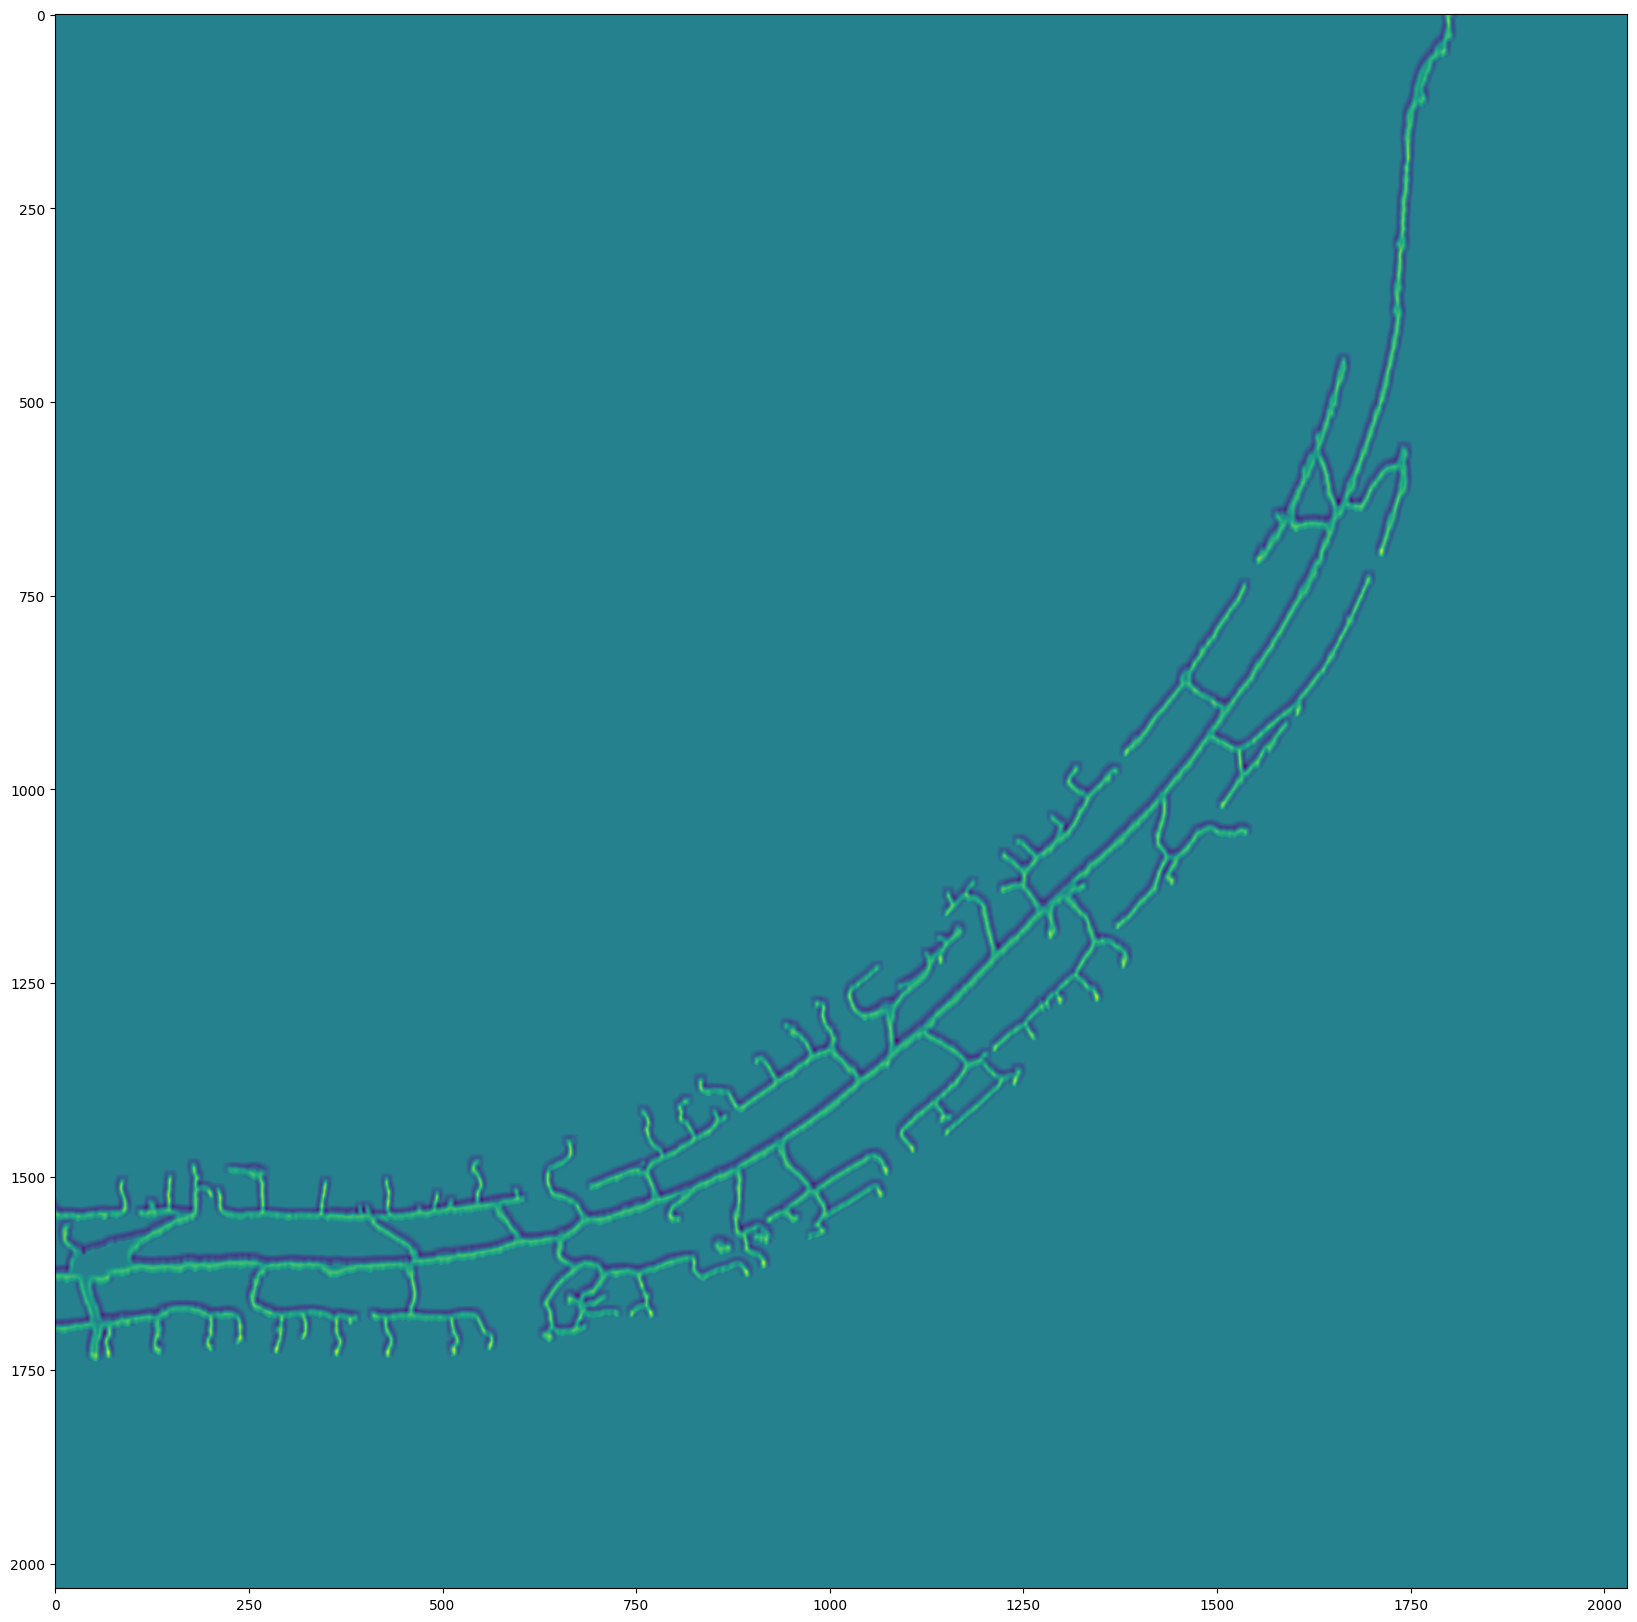

In [687]:
# Plot Template match image
fig, ax = plt.subplots(figsize=(img.shape[0]/100, img.shape[0]/100))
ax.imshow(res)

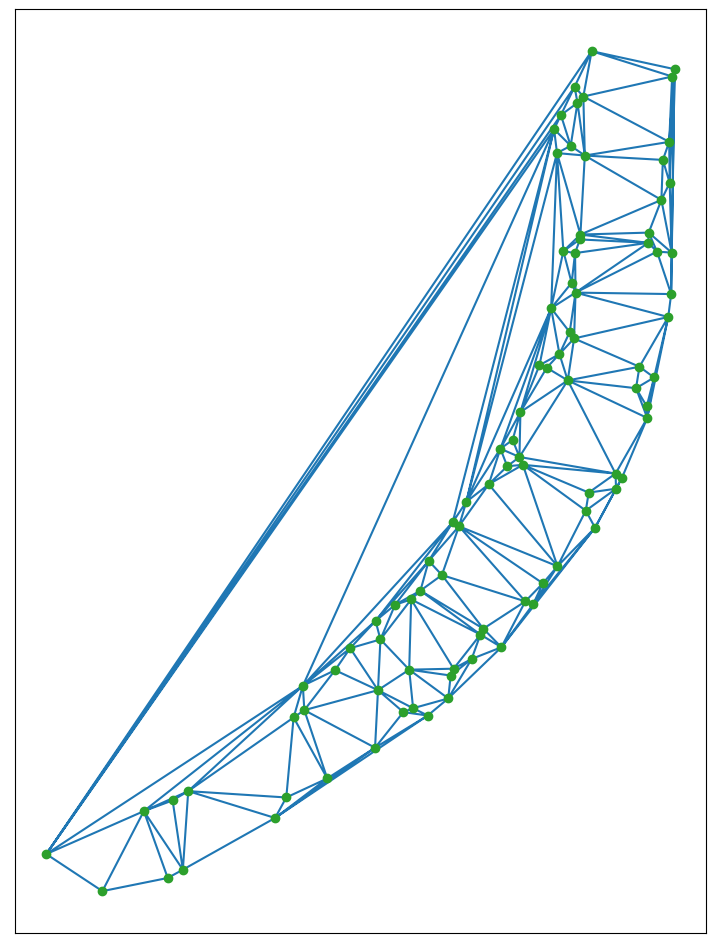

In [688]:
delaunay = Delaunay(knots)

plt.figure(figsize=(12, 12))
plt.triplot(knots[:, 0], -knots[:, 1], delaunay.simplices)
plt.plot(knots[:, 0], -knots[:, 1], 'o')

plt.gca().set_aspect('equal', adjustable='box')
plt.xticks([])
plt.yticks([])

plt.show()

In [689]:
delaunay.simplices

array([[49, 67, 58],
       [37, 66, 75],
       [75, 66, 58],
       [12, 75, 91],
       [12, 37, 75],
       [45, 66, 37],
       [60, 49, 58],
       [66, 60, 58],
       [45, 60, 66],
       [48, 47,  0],
       [47, 48, 58],
       [67, 47, 58],
       [63, 47, 67],
       [70, 64, 63],
       [47, 64,  0],
       [17, 63, 67],
       [12, 93, 37],
       [93, 12, 91],
       [36, 39, 49],
       [21, 47, 63],
       [64, 21, 63],
       [21, 64, 47],
       [35, 67, 76],
       [ 7,  9, 15],
       [93,  9,  7],
       [ 9, 93, 91],
       [ 1, 87, 14],
       [25, 89, 14],
       [89, 25,  3],
       [52, 32,  6],
       [86,  7, 15],
       [86, 45, 37],
       [93, 86, 37],
       [86, 93,  7],
       [33,  8, 80],
       [ 8,  6, 80],
       [85, 33, 32],
       [85,  8, 33],
       [32, 79,  6],
       [33, 79, 32],
       [79, 33, 80],
       [56, 68, 61],
       [35, 41, 67],
       [41, 35, 84],
       [35, 28, 84],
       [28, 18, 84],
       [28, 35, 76],
       [19, 1